In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Download dataset

In [2]:
# method1. upload dataset manually (very slow)
# from google.colab import files
# uploaded = files.upload()

In [3]:
# method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

#1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

#2. Click on Create New API Token - It will download kaggle.json file on your machine.

#3. Go to your Google Colab project file and run the following commands:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# unzip dataset
!kaggle competitions download -c computer-vision-hw4
!unzip computer-vision-hw4.zip
!ls -alh

Streaming output truncated to the last 5000 lines.
  inflating: ccpd6000/test_images/1010.jpg  
  inflating: ccpd6000/test_images/1011.jpg  
  inflating: ccpd6000/test_images/1012.jpg  
  inflating: ccpd6000/test_images/1013.jpg  
  inflating: ccpd6000/test_images/1014.jpg  
  inflating: ccpd6000/test_images/1015.jpg  
  inflating: ccpd6000/test_images/1016.jpg  
  inflating: ccpd6000/test_images/1017.jpg  
  inflating: ccpd6000/test_images/1018.jpg  
  inflating: ccpd6000/test_images/1019.jpg  
  inflating: ccpd6000/test_images/1020.jpg  
  inflating: ccpd6000/test_images/1021.jpg  
  inflating: ccpd6000/test_images/1022.jpg  
  inflating: ccpd6000/test_images/1023.jpg  
  inflating: ccpd6000/test_images/1024.jpg  
  inflating: ccpd6000/test_images/1025.jpg  
  inflating: ccpd6000/test_images/1026.jpg  
  inflating: ccpd6000/test_images/1027.jpg  
  inflating: ccpd6000/test_images/1028.jpg  
  inflating: ccpd6000/test_images/1029.jpg  
  inflating: ccpd6000/test_images/1030.jpg  
  in

In [5]:
# !sudo kill -9 0
!nvidia-smi


Tue Dec 27 17:27:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import warnings

import torch
import numpy as np
from PIL import Image, ImageDraw
from skimage import util
from skimage.transform import ProjectiveTransform, warp

def draw_kpts(img, kpts, c='red', r=2.0):
    '''Draw keypoints on image.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
        c: (PIL.Color) color of keypoints, default to 'red'
        r: (float) radius of keypoints, default to 2.0
    Return:
        img: (PIL.Image) modified image
    '''
    draw = ImageDraw.Draw(img)
    kpts = kpts.view(4, 2)
    kpts = kpts * torch.FloatTensor(img.size)
    kpts = kpts.numpy().tolist()
    for (x, y) in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img


def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Init and Utility

In [11]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [12]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

# Data Preprocess

reference : 

In [9]:
import os
os.mkdir(str(ROOT_DIR) + '/train')
os.mkdir(str(ROOT_DIR) + '/val')

In [10]:
import csv

# split training dataset into validation set and training set

def split_dataset(root, csv_path, img_dir):

  train_labels = []
  val_labels = []

  with open(csv_path, newline='') as csvfile:
    rows = list(csv.reader(csvfile))
    #print(rows[0])
    train_labels.append(rows[0])
    val_labels.append(rows[0])

    pivot = len(rows) * 1 // 5

    for i in range(1, pivot):
      val_labels.append(rows[i])

    for i in range(pivot, len(rows)):
      train_labels.append(rows[i])
  
  
  with open(root / 'train_data.csv', 'w', newline='') as csvfile:
    
    writer = csv.writer(csvfile)

    for row in train_labels:
      writer.writerow(row)

    for i in range(1, len(train_labels)):
      img_src_path = str(root) + '/train_images/' + train_labels[i][0]
      print(img_src_path)
      img_dest_path = str(root) + '/train/' + train_labels[i][0]
      Path(img_src_path).replace(img_dest_path)

  with open(root / 'val_data.csv', 'w', newline='') as csvfile:
    
    writer = csv.writer(csvfile)

    for row in val_labels:
      writer.writerow(row)
    
    for i in range(1, len(val_labels)):
      img_src_path = str(root) + '/train_images/' + val_labels[i][0]
      img_dest_path = str(root) + '/val/' + val_labels[i][0]
      Path(img_src_path).replace(img_dest_path)

  trainData_count = len(rows)

  return trainData_count

trainData_count = split_dataset(ROOT_DIR, ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')

ccpd6000/train_images/0599.jpg
ccpd6000/train_images/0600.jpg
ccpd6000/train_images/0601.jpg
ccpd6000/train_images/0602.jpg
ccpd6000/train_images/0603.jpg
ccpd6000/train_images/0604.jpg
ccpd6000/train_images/0605.jpg
ccpd6000/train_images/0606.jpg
ccpd6000/train_images/0607.jpg
ccpd6000/train_images/0608.jpg
ccpd6000/train_images/0609.jpg
ccpd6000/train_images/0610.jpg
ccpd6000/train_images/0611.jpg
ccpd6000/train_images/0612.jpg
ccpd6000/train_images/0613.jpg
ccpd6000/train_images/0614.jpg
ccpd6000/train_images/0615.jpg
ccpd6000/train_images/0616.jpg
ccpd6000/train_images/0617.jpg
ccpd6000/train_images/0618.jpg
ccpd6000/train_images/0619.jpg
ccpd6000/train_images/0620.jpg
ccpd6000/train_images/0621.jpg
ccpd6000/train_images/0622.jpg
ccpd6000/train_images/0623.jpg
ccpd6000/train_images/0624.jpg
ccpd6000/train_images/0625.jpg
ccpd6000/train_images/0626.jpg
ccpd6000/train_images/0627.jpg
ccpd6000/train_images/0628.jpg
ccpd6000/train_images/0629.jpg
ccpd6000/train_images/0630.jpg
ccpd6000

In [11]:
trainData_count = len(os.listdir(str(ROOT_DIR) + '/train')) + len(os.listdir(str(ROOT_DIR) + '/val'))
trainData_count

3000

In [12]:
import torchvision.transforms.functional as F_
import copy

def Adjust_contrast(image):
    return F_.adjust_contrast(image,2)

def Adjust_brightness(image):
    return F_.adjust_brightness(image, 2)

def Adjust_saturation(image):
    return F_.adjust_saturation(image, 2)

def lighting_noise(image):
    '''
        color channel swap in image
        image: A PIL image
    '''
    new_image = image
    perms = ((0, 1, 2), (0, 2, 1), (1, 0, 2), 
             (1, 2, 0), (2, 0, 1), (2, 1, 0))
    swap = perms[random.randint(0, len(perms)- 1)]
    new_image = F_.to_tensor(new_image)
    new_image = new_image[swap, :, :]
    new_image = F_.to_pil_image(new_image)
    return new_image

def flip(image, label):
    '''
        Flip image horizontally.
        image: a PIL image
        boxes: Bounding boxes, a tensor of dimensions (#objects, 4)
    '''
    new_image = F_.hflip(image)
    
    #flip boxes 
    '''
    new_boxes = boxes.clone()
    new_boxes[:, 0] = image.width - boxes[:, 0]
    new_boxes[:, 2] = image.width - boxes[:, 2]
    new_boxes = new_boxes[:, [2, 1, 0, 3]]
    '''

    new_label = copy.deepcopy(label)
    new_label[0] = str(image.width - float(label[0]))
    new_label[2] = str(image.width - float(label[2]))
    new_label[4] = str(image.width - float(label[4]))
    new_label[6] = str(image.width - float(label[6]))

    return new_image, new_label

In [13]:
from PIL import Image, ImageDraw #version 6.1.0
# augmentation training dataset

train_labels = []

with open(ROOT_DIR / 'train_data.csv', newline='') as csvfile:
    train_labels = list(csv.reader(csvfile))

n = len(train_labels)

print(train_labels)
print()
print(ROOT_DIR)
for i in range (1, n):
  
    image = Image.open(str(ROOT_DIR) + '/train/' + train_labels[i][0], mode= "r")
    image = image.convert("RGB")

    
    new_image = lighting_noise(image)
    path = str(ROOT_DIR) + '/train/'  + str(trainData_count) + '.jpg'
    new_image.save(path)
    train_labels.append([str(trainData_count) + '.jpg'] + [train_labels[i][j] for j in range(1, len(train_labels[i]))])
    
    new_image = Adjust_saturation(image)
    path = str(ROOT_DIR) + '/train/'  + str(trainData_count+1) + '.jpg'
    new_image.save(path)
    train_labels.append([str(trainData_count+1) + '.jpg'] + [train_labels[i][j] for j in range(1, len(train_labels[i]))])

    '''
    new_image = Adjust_brightness(image)
    path = str(ROOT_DIR) + '/train/'  + str(trainData_count+2) + '.jpg'
    new_image.save(path)
    train_labels.append([str(trainData_count+2) + '.jpg'] + [train_labels[i][j] for j in range(1, len(train_labels[i]))])
    '''
    '''
    new_image = Adjust_contrast(image)
    path = str(ROOT_DIR) + '/train/'  + str(trainData_count+3) + '.jpg'
    new_image.save(path)
    train_labels.append([str(trainData_count+3) + '.jpg'] + [train_labels[i][j] for j in range(1, len(train_labels[i]))])
    
    
    new_image, new_label = flip(image, train_labels[i][1:len(train_labels[i])])
    path = str(ROOT_DIR) + '/train/'  + str(trainData_count) + '.jpg'
    new_image.save(path)
    train_labels.append([str(trainData_count) + '.jpg'] + new_label)
    '''
    trainData_count += 2


with open(ROOT_DIR / 'train_data.csv', 'w+', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerows(train_labels)

[['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'], ['0599.jpg', '527.000', '556.000', '161.000', '567.000', '164.000', '471.000', '530.000', '460.000'], ['0600.jpg', '313.000', '509.000', '71.000', '536.000', '66.000', '451.000', '308.000', '424.000'], ['0601.jpg', '434.000', '534.000', '230.000', '537.000', '220.000', '480.000', '424.000', '477.000'], ['0602.jpg', '472.000', '535.000', '200.000', '602.000', '191.000', '514.000', '463.000', '447.000'], ['0603.jpg', '553.000', '549.000', '245.000', '550.000', '244.000', '459.000', '552.000', '457.000'], ['0604.jpg', '631.000', '474.000', '378.000', '474.000', '379.000', '404.000', '632.000', '405.000'], ['0605.jpg', '409.000', '536.000', '224.000', '533.000', '218.000', '483.000', '404.000', '487.000'], ['0606.jpg', '409.000', '450.000', '208.000', '448.000', '211.000', '399.000', '411.000', '401.000'], ['0607.jpg', '403.000', '554.000', '193.000', '533.000', '192.000', '467.000', '402.000', '487.000'], ['0608.jp

# Training Data

In [ ]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        
        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]
        
        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train_data.csv', ROOT_DIR / 'train')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [ ]:
from torchsummary import summary
import torchvision


class ConvBlock(nn.Module):
    def __init__(self, cin, cout, kernel=3, padding=1, stride=1):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (kernel, kernel)
                          , padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        self.features = torchvision.models.resnet18()
        
        # TODO : add ouput layer to predict position
        self.fc1 = nn.Linear(1000, 512)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(512, 128)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(128, 8)
        self.act3 = nn.Sigmoid()

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            out: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''

        x = self.features(img_b)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        out = x
        
        return out


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]
# Do a forwarding
#device = 'gpu'     # the computing device, 'cuda' or 'cpu'
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Net().to(device) # instantiate network and move it to device
summary(model, (3, 320, 192))
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

# Training

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


lr: 5e-05
Epoch 000:
train loss: 0.05826027359677312
valid loss: 0.04667492315173149
train mse: 0.006368319025925327
valid mse: 0.004270342215895653
lr: 5e-05
Epoch 001:
train loss: 0.03883442978848056
valid loss: 0.025890416353940963
train mse: 0.0032653637352999783
valid mse: 0.0013279364374466241
lr: 5e-05
Epoch 002:
train loss: 0.02469669796365539
valid loss: 0.031037502959370612
train mse: 0.0012722694075417292
valid mse: 0.0017055214010179042
lr: 5e-05
Epoch 003:
train loss: 0.020900221241396726
valid loss: 0.018922813460230826
train mse: 0.0008930984234353806
valid mse: 0.0006920672440901399
lr: 5e-05
Epoch 004:
train loss: 0.018560043186493885
valid loss: 0.018259617686271667
train mse: 0.0006996062056291415
valid mse: 0.0006075906951446086
lr: 5e-05
Epoch 005:
train loss: 0.017239295942492263
valid loss: 0.020063279047608375
train mse: 0.0006012828436899046
valid mse: 0.0007684252713806928
lr: 5e-05
Epoch 006:
train loss: 0.01561353667221493
valid loss: 0.016120791360735895
tr

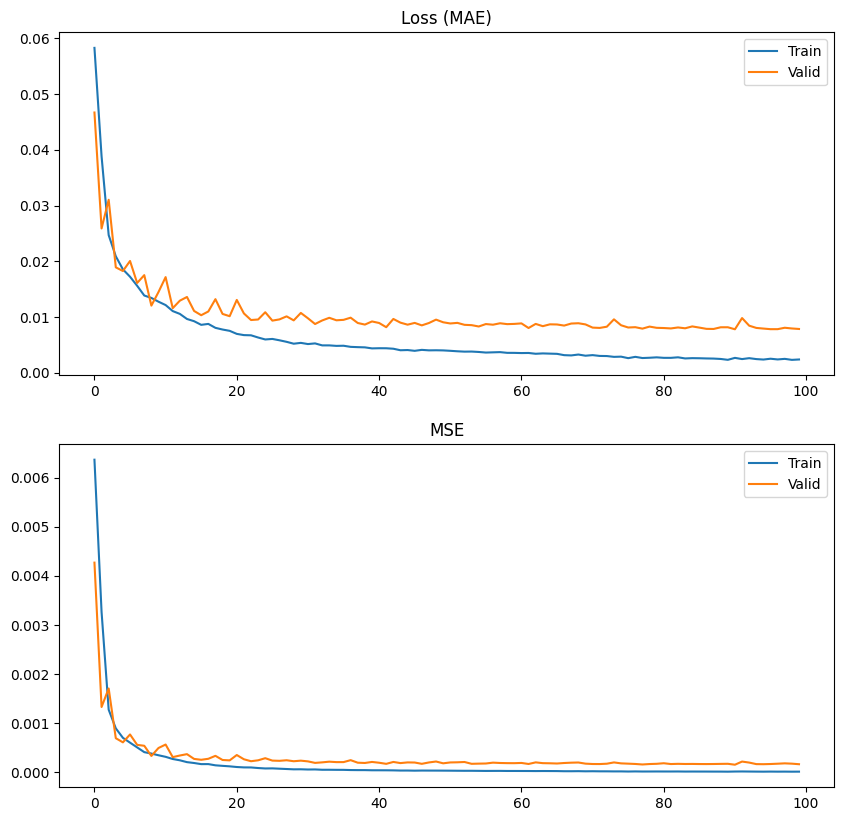

In [16]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        '''
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        #print(self.train_set)
        #print(self.valid_set)
        '''
        self.train_set = TrainData(ROOT_DIR / 'train_data.csv', ROOT_DIR / 'train')
        self.train_set = Subset(TrainData(ROOT_DIR / 'train_data.csv', ROOT_DIR / 'train'), range(len(self.train_set)))
        self.valid_set = TrainData(ROOT_DIR / 'val_data.csv', ROOT_DIR / 'val')
        self.valid_set = Subset(TrainData(ROOT_DIR / 'val_data.csv', ROOT_DIR / 'val'), range(len(self.valid_set)))
        print(self.train_set)
        print(self.valid_set)
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 24, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 24, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 24, shuffle=False)

        # model, loss function, optimizer
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.0005, momentum=0.9)
        #self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=9e-5)
        self.optimizer = opt_Adam = torch.optim.Adam(self.model.parameters(), lr=5e-5)#, betas=(0.9, 0.99), eps=1e-06, weight_decay=0.0005)
        self.max_epoch = 100 #TODO define your training epochs

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': [], 'train_mse': [], 'valid_mse': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss, train_mse = self.train() # train 1 epoch
            valid_loss, valid_mse = self.valid() # valid 1 epoch
            self.visul()              # visualization
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            print('train mse:', train_mse)
            print('valid mse:', valid_mse)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            metrics['train_mse'].append(train_mse)
            metrics['valid_mse'].append(valid_mse)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_mse']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))
            if self.epoch > (self.max_epoch - 8):
                torch.save(self.model.state_dict(), str(training_result_dir / 'model{0}.pth'.format(self.epoch)))

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
        ax[0].set_title('Loss (MAE)')
        ax[0].plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax[0].plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax[0].legend()
        ax[1].set_title('MSE')
        ax[1].plot(range(self.epoch + 1), metrics['train_mse'], label='Train')
        ax[1].plot(range(self.epoch + 1), metrics['valid_mse'], label='Valid')
        ax[1].legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            # TODO 
            # step 1 caculate the loss 
            loss = self.criterion(pred_b, kpt_b)
            # step 2 back propagation
            loss.backward()
            # step 3 update parameters using optimizer
            self.optimizer.step()
            
            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

# Testing

In [19]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
# model.load_state_dict(torch.load('runs/Jan.14 11:12:28/training_result/model.pth'))
model.eval()

log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            # print(kpt)
            # print(kpt[0:-1:2])
            # print(kpt[1::2])
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

testing_result/Dec.28 03:33:58


100%|██████████| 3000/3000 [01:24<00:00, 35.42it/s]


In [8]:
import shutil
import os
os.listdir()
img_src_path = 'ccpd6000/test_pred.csv'
img_dest_path = 'gdrive/MyDrive/CV/test_pred2.csv'
#shutil.move(img_src_path, img_dest_path)

img_src_path = 'runs/Dec.27 17:31:28/training_result'
img_dest_path = 'gdrive/MyDrive/CV/runs2/Dec.27 17:31:28/training_result'
shutil.move(img_dest_path, img_src_path)
log_dir = 'Dec.27 17:31:28'

In [18]:
log_dir = 'runs/Dec.27 17:31:28/'

In [ ]:
display.Image(str(log_dir / '001' / '026.jpg')) # A visualization of validation data in epoch 4

In [ ]:
display.Image(str(log_dir / '003' / '026.jpg')) # A visualization of validation data in epoch 10

In [ ]:
display.Image(str(log_dir / 'training_result/metrics.jpg')) # Loss

# Report

1. model : Resnet18 + 3 Dense Layer
2. learning rate : 
3. Loss Function : L1 Norm
4. Training Epochs : 100
5. Data Augmentation
  - Change the Brightness of image
  - Adjust image contrast
  - Add Noise
  - Adjust Saturation
6. Loss during training process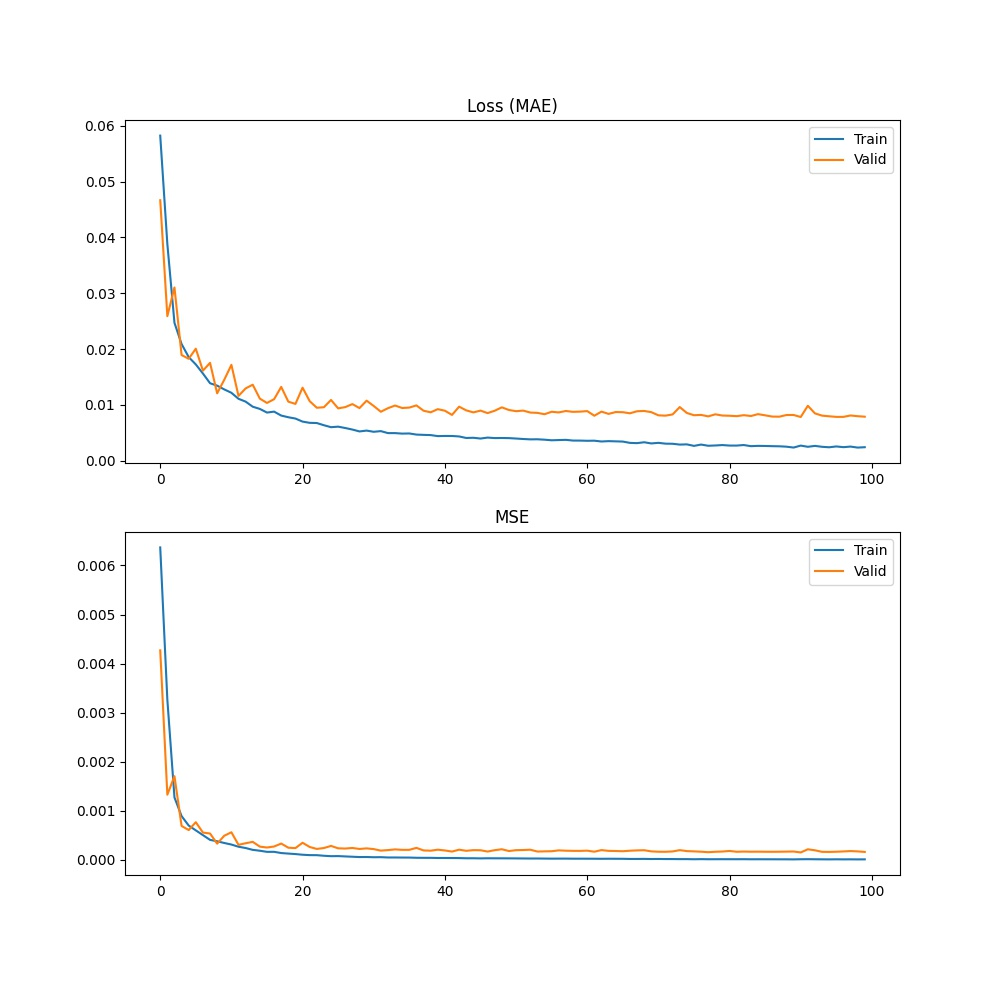
  